# Setup Notebook (Virtual machine)

In this section all required packages will be installed.

In [34]:
!pip install setuptools==65.5.1
!wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
import utils
!apt install -y xvfb x11-utils python-opengl ffmpeg 
!pip install -U gym[atari,accept-rom-license]==0.22.0
!pip install torch
# ! pip install -U gym==0.19.0
!pip install opencv-python
!pip install onnx onnx2pytorch
!pip install pyvirtualdisplay
!pip install gym_minigrid==1.1.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-22 20:19:05--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   4.41K  --.-KB/s    in 0s      

2023-05-22 20:19:06 (65.9 MB/s) - ‘utils.py.1’ saved [4519/4519]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+5).
python-opengl is already the newest version (3.1.0+dfsg-2build1).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubunt

In [35]:
import time 
from datetime import datetime
import numpy as np
from collections import deque, namedtuple
import collections
import os
import time
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import gym
import gym.spaces

import matplotlib.pyplot as plt
import copy
%matplotlib inline
!nvcc --version

from matplotlib import animation
import seaborn as sns; sns.set()
from IPython.display import clear_output, HTML
from IPython import display

import torch.onnx

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


# Mount your drive and use GPU

Here you can mount your GDrive folders (where you will store checkpoints during training).

In [36]:
if not os.path.exists('/content/gdrive'):
    from google.colab import drive
    drive.mount('/content/gdrive')

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
print(device)

cuda


# Replay Buffer

The replay buffer stores transitions - state, action, reward, next_state. 

In [38]:
class ReplayBuffer():
  def __init__(self, num_actions, memory_len = 10000):
      self.memory_len = memory_len
      self.transition = []
      self.num_actions = num_actions

  def add(self, state, action, reward, next_state, done):
      if self.length() > self.memory_len:
        self.remove()
      self.transition.append(Transition(state, action, reward, next_state, done))

  def sample_batch(self, batch_size = 32):
      minibatch = random.sample(self.transition, batch_size)
      states_mb, a_, reward_mb, next_states_mb, done_mb = map(np.array, zip(*minibatch))

      mb_reward = torch.from_numpy(reward_mb).to(device=device, dtype=torch.float32)
      mb_done = torch.from_numpy(done_mb.astype(int)).to(device=device)
      a_ = a_.astype(int)
      a_mb = np.zeros((a_.size, self.num_actions), dtype=np.float32)
      a_mb[np.arange(a_.size), a_] = 1
      mb_a = torch.from_numpy(a_mb).to(device=device)
      return states_mb, mb_a, mb_reward, next_states_mb, mb_done # states will be converted to tensors in forward pass

  def length(self):
      return len(self.transition)

  def remove(self):
      self.transition.pop(0)

# MINIGRID DQN-Training

This section contains the train function for the minigrid environment.

### Minigrid Environment and Policy Network





In [39]:
# Minigrid Environment
from gym_minigrid.wrappers import ImgObsWrapper
class ChannelFirst(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = env.observation_space.shape
        self.observation_space = {}
        self.observation_space = gym.spaces.Box(0, 255, shape=(3, 7, 7))

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32)

class MinigridEmpty5x5ImgObs(gym.Wrapper):
    """Minigrid with image observations provided by minigrid, partially observable."""
    def __init__(self):
        env = gym.make('MiniGrid-Empty-5x5-v0')
        env = ScaledFloatFrame(ChannelFirst(ImgObsWrapper(env)))
        super().__init__(env)

In [40]:
env = MinigridEmpty5x5ImgObs()
obs = env.reset()
obs, obs.shape, env.action_space

(array([[[2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 1., 1., 8., 2.],
         [2., 2., 2., 1., 1., 1., 2.],
         [2., 2., 2., 1., 1., 1., 2.]],
 
        [[5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 0., 0., 1., 5.],
         [5., 5., 5., 0., 0., 0., 5.],
         [5., 5., 5., 0., 0., 0., 5.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32),
 (3, 7, 7),
 Discrete(7))

In [41]:
class MlpMinigridPolicy(nn.Module):
    def __init__(self, num_actions=7):
        super().__init__()
        self.num_actions = num_actions
        self.fc = nn.Sequential(nn.Flatten(), 
                                nn.Linear(3*7**2, 256), nn.ReLU(),
                                nn.Linear(256, 256), nn.ReLU(),
                                nn.Linear(256, 64), nn.ReLU(),
                                nn.Linear(64, num_actions))
    def forward(self, x):
        # print(x, type(x))
        x = torch.tensor(x, dtype=torch.float32, device=device)
        if len(x.size()) == 3:
          x = x.unsqueeze(dim=0)
        return self.fc(x)

In [42]:
mlp_minigrid_policy = MlpMinigridPolicy().to(device)
mlp_minigrid_policy(obs)

tensor([[ 0.0929,  0.0307,  0.1727,  0.0114, -0.1152, -0.1065, -0.0392]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

### Training utils

In [43]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [44]:
# Update Target network
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [45]:
def set_seed(env, seed=None):
    if seed is not None:
        random.seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


### DQN Hyperparameters

In [46]:
num_episodes = 1000 # number of episodes to run the algorithm -> the algorithm should reach a score of about 0.9 within 1000 episodes
buffer_size = 100_000 # size of the buffer to use
epsilon = 1.0 # initial probablity of selecting random action a, annealed over time
timesteps = 0 # counter for number of frames
minibatch_size = 128 # size of the minibatch sampled
gamma = 0.99 # discount factor
eval_episode = 100
num_eval = 10
tau = 1e-3 
learning_rate = 0.0001
update_after = 2000 # update after num time steps
epsilon_decay = 100_000 # decay epsilon in 100.000 timesteps
epsilon_ub = 1.0
epsilon_lb = 0.3
# set seed
np.random.seed(0)
torch.manual_seed(0)

In [47]:
# Initialize environment
env = MinigridEmpty5x5ImgObs()

num_actions = env.action_space.n
state_space = env.observation_space.shape
print(num_actions, state_space)
obs, obs.shape, env.action_space

7 (3, 7, 7)


(array([[[2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 1., 1., 8., 2.],
         [2., 2., 2., 1., 1., 1., 2.],
         [2., 2., 2., 1., 1., 1., 2.]],
 
        [[5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 0., 0., 1., 5.],
         [5., 5., 5., 0., 0., 0., 5.],
         [5., 5., 5., 0., 0., 0., 5.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32),
 (3, 7, 7),
 Discrete(7))

### Load model (if available)

In [48]:
print(device)

cuda


In [49]:
# specify load path if available:

# load_path = '/content/gdrive/MyDrive/colab-drive/minigrid-model-2022_03_28-10_01_18.p'

load_path = '' # otherwise start with randomly initialized agent

# save the current model state
save_path =  'gdrive/MyDrive/Deep_Reinforcement_Learning/model_as2_small_env/' + f"minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.pt" #f"/content/gdrive/MyDrive/colab-drive/minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.p"
print(f'model checkpoints will be saved to: {save_path}')

def load_checkpoint(checkpoint_path='', device=device):
  dqn = MlpMinigridPolicy(num_actions=num_actions).to(device=device)
  dqn_target = MlpMinigridPolicy(num_actions=num_actions).to(device=device)
  timesteps = 0

  if checkpoint_path:
    print(f'Loading checkpoint {checkpoint_path}')
    checkpoint_dict = torch.load(checkpoint_path, map_location=device)
    model_params = checkpoint_dict['model_params']
    timesteps = checkpoint_dict['timesteps'] # environment steps

    dqn.load_state_dict(model_params) # makes a copy of model_params
    dqn_target.load_state_dict(model_params)
  else:
    print(f'Starting training from scratch.')

  return dqn, dqn_target, timesteps

def store_checkpoint(checkpoint_path, dqn_net, timesteps):
  checkpoint_dict = {'model_params':dqn_net.state_dict(), 'timesteps': timesteps}
  torch.save(checkpoint_dict, checkpoint_path)

model checkpoints will be saved to: gdrive/MyDrive/Deep_Reinforcement_Learning/model_as2_small_env/minigrid-model-2023_05_22-20_19_54.pt


### DQN training loop

**TODO**: Implement DQN algorithm (lines highlighted with TODO)

In [50]:
from torch.serialization import load

# Train the agent using DQN for Pong
returns = []
returns_50 = deque(maxlen=50)
losses = []
buffer = ReplayBuffer(num_actions=num_actions, memory_len=buffer_size)
dqn, dqn_target, timesteps = load_checkpoint(load_path)

optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
mse = torch.nn.MSELoss()
state = env.reset()
for i in range(num_episodes):
  ret = 0
  done = False
  while not done:
    # Decay epsilon
    epsilon = max(epsilon_lb, epsilon_ub - timesteps/ epsilon_decay)
    # action selection
    if np.random.choice([0,1], p=[1-epsilon,epsilon]) == 1:
      a = np.random.randint(low=0, high=num_actions, size=1)[0]
    else:
      net_out = dqn(state).detach().cpu().numpy()
      a = np.argmax(net_out)
    next_state, r, done, info = env.step(a)
    ret = ret + r
    # TODO: store transition in replay buffer 
    # ....
    buffer.add(state, a, r, next_state, done)

    state = next_state
    timesteps = timesteps + 1

    # update policy using temporal difference
    if buffer.length() > minibatch_size and buffer.length() > update_after:
      optimizer.zero_grad()
      # TODO: Sample a minibatch randomly
      sampled_mini_batch = buffer.sample_batch(batch_size=minibatch_size)
      states_mb, mb_a, mb_reward, next_states_mb, mb_done = sampled_mini_batch

      # ....      
      # TODO: Compute q values for states
      net_out_batched = dqn_target(next_states_mb)

      sorted_idx = torch.argsort(net_out_batched, dim=1)
      max_Q_batched = torch.take_along_dim(net_out_batched, sorted_idx, dim=1)
      max_Q_batched = max_Q_batched[:,-1] # shape [128,]

      # ....
      # ....
      # TODO: compute the targets for training
      max_Q_batched[mb_done] = 0
      target_batched = mb_reward + gamma * max_Q_batched
      targets = target_batched

      # ....
      # TODO: compute the predictions for training
      predictions_allQs = dqn(states_mb)
      predictions = predictions_allQs[mb_a.to(torch.bool)]

      # ....
      # Update loss: mse = mean squared error
      loss = mse(predictions, targets) 
      loss.backward(retain_graph=False)
      optimizer.step()
      losses.append(loss.item())
 
      # Update target network
      soft_update(dqn, dqn_target, tau)
    if done:
      state = env.reset()
      print(f"Episode: \t{i}\t{ret}\t{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}")
      break
  returns.append(ret)
  returns_50.append(ret)
  if i % 50 == 0:
    store_checkpoint(checkpoint_path=save_path, dqn_net=dqn, timesteps=timesteps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(returns_50)))   

Starting training from scratch.
Episode: 	0	0	2023_05_22-20_19_54
Episode 0	Average Score: 0.00
Episode: 	1	0	2023_05_22-20_19_55
Episode: 	2	0.29799999999999993	2023_05_22-20_19_55
Episode: 	3	0.352	2023_05_22-20_19_55
Episode: 	4	0	2023_05_22-20_19_55
Episode: 	5	0	2023_05_22-20_19_55
Episode: 	6	0.5680000000000001	2023_05_22-20_19_55
Episode: 	7	0.748	2023_05_22-20_19_55
Episode: 	8	0	2023_05_22-20_19_55
Episode: 	9	0	2023_05_22-20_19_56
Episode: 	10	0	2023_05_22-20_19_56
Episode: 	11	0	2023_05_22-20_19_56
Episode: 	12	0	2023_05_22-20_19_56
Episode: 	13	0.118	2023_05_22-20_19_56
Episode: 	14	0.5680000000000001	2023_05_22-20_19_56
Episode: 	15	0	2023_05_22-20_19_56
Episode: 	16	0	2023_05_22-20_19_56
Episode: 	17	0.32499999999999996	2023_05_22-20_19_56
Episode: 	18	0	2023_05_22-20_19_56
Episode: 	19	0	2023_05_22-20_19_56
Episode: 	20	0	2023_05_22-20_19_56
Episode: 	21	0	2023_05_22-20_19_56
Episode: 	22	0	2023_05_22-20_19_56
Episode: 	23	0	2023_05_22-20_19_57
Episode: 	24	0	2023_05_22-

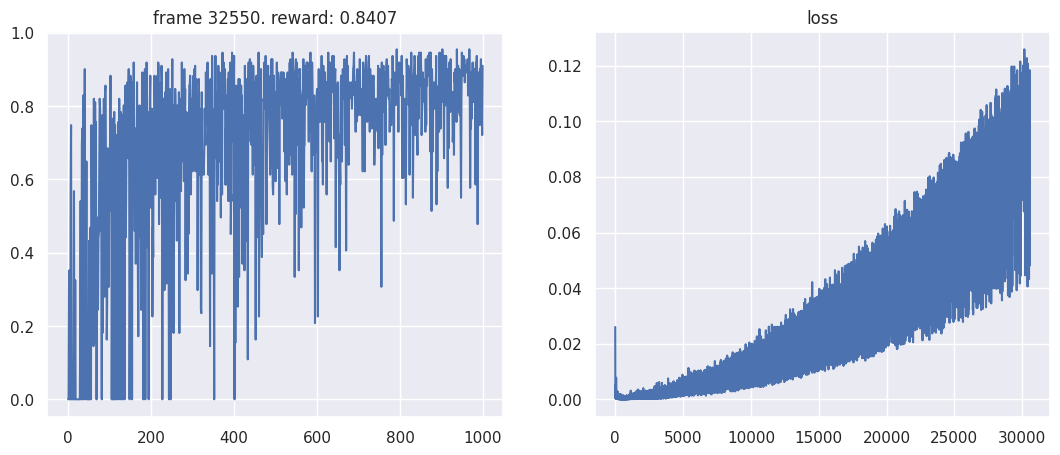

In [51]:
plot(timesteps, returns, losses)

### Record video of your Agent

In [52]:
import glob
import glob
import io
import base64
from gym.wrappers import Monitor
# start virtual display
# from pyvirtualdisplay import Display
# pydisplay = Display(visible=0, size=(640, 480))
# pydisplay.start()
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env_video(env):
    env = Monitor(env, './video', force=True)
    return env

In [53]:
video_env = wrap_env_video(env)
state = video_env.reset()
ret = 0
done = False
while not done:
  state_tensor = torch.tensor(state, dtype=torch.float, device=device)
  # state_tensor = state_tensor.unsqueeze(dim=0)
  q_actions = dqn(state_tensor).detach().cpu().numpy()
  action = np.argmax(q_actions)
  state, r, done, _ = video_env.step(action)
  ret += r
video_env.close()
print(f"Episode Return: {ret}")
show_video() # if not shown properly, just download the video in the "video" folder
# if the agent is not moving or not reaching the goal, restart training

<ipython-input-41-93c1066cc340>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=device)


Episode Return: 0.955


# PONG DQN-Training

This section contains the train function for the Pong environment.

### Atari Wrappers

In this section all [OpenAI Gym wrappers](https://www.gymlibrary.ml/pages/api/#wrappers) used in the original [DQN-Atari paper](https://hallab.cs.dal.ca/images/0/00/Minh2015.pdf) are defined.

note: this code cell is mainly a copy from https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py 

In [7]:
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1)

#            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [8]:
def test_environment(env, agent=None):
    state = env.reset()

    prev_screen = env.render(mode='rgb_array')
    plt.axis('off')
    plt.imshow(prev_screen)

    for i in range(200):
        env.render()

        if agent is None:
            action = env.action_space.sample()
        else:
            action, _ = agent(state)
            action = action.item()
        state, reward, done, info = env.step(action)
        if done:
            env.reset()

    env.close()

### DQN Atari Network

Here, the DQN network class is defined. 
It has a couple of CNN layers (as the observations are images - CNN layers almost always work best for image inputs) followed by linear layers with the number of outputs.
See the [DQN Atari paper](https://hallab.cs.dal.ca/images/0/00/Minh2015.pdf) for details.

`forward` should give for a state / observation the expected return from t to T for every possible action, such that we can use argmax on the outputs later to determine the action.


**TODO:** Implement network architecture

In [9]:
class DQNNetwork_atari(nn.Module):

    def __init__(self, num_actions = 4):
        super().__init__()

        self.num_actions = num_actions
        # Network Architecture
        # 4 input image channels, 16 output channels, 8x8 square convolution, stride=4, with relus --> layer 1
        # 16 input channels, 32 output channels, 4x4 square convolution, stride=2, with relus --> layer 2
        # 256 units linear layer, with relus --> layer 3
        self.features = nn.Sequential(
            # TODO
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(8,8), stride=(4,4), padding=0, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4,4), stride=(2,2), padding=0, bias=True),
            nn.ReLU()
          )
          
        self.fc = nn.Sequential(
            # TODO
            nn.Linear(in_features=2592, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.num_actions, bias=True),
          )

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float).to(device=device)
        if len(x.size()) == 3:
          x = x.unsqueeze(dim=0)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Keep notebook alive
Don't forget to run the following function on the console of the virtal machine as soon as you have started.
(For details we refer to the technical tutorial)
1. Press `F12` or `Ctrl+Shift+I` and go to Console and paste the following code:
``` javascript
function random(min,max) { return Math.floor((Math.random())*(max-min+1))+min; }
function ClickConnect(){
console.log("Try keepalive");
cells = document.querySelectorAll("div.main-content > div.codecell-input-output > div.output");
idx = random(0, cells.length);
cells[idx].click();
recapt = document.querySelector(".recaptcha-checkbox");
if (recapt == null) {
recapt.click();
}
}
var keepAlive = setInterval(ClickConnect,6000)
```
2. Stop `keepAlive` when you continue with on the notebook.
``` javascript
clearInterval(keepAlive)
```

In [10]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [11]:
# Update Target network
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [12]:
def set_seed(env, seed=None):
    if seed is not None:
        random.seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


### DQN Hyperparameters

**TODO**: Try out other hyperparameters

In [13]:
env_id = "PongNoFrameskip-v4"
num_episodes =  400         # 500 #1000 #600 # number of episodes to run the algorithm
buffer_size =             1e5 #10 ** 5 * 3 # size of the buffer to use
epsilon =  0.5              # 1.0 # initial probablity of selecting random action a, annealed over time
timesteps =               0 # counter for number of frames
minibatch_size = 28        # 128 # size of the minibatch sampled
gamma =                   0.99 # discount factor
eval_episode =            100
num_eval =                10
tau =                     1e-3 
learning_rate =     1e-4     # 0.00001
update_after =       1000    # 2000 # update after num time steps
epsilon_decay =           10**5
epsilon_ub =              1.0
epsilon_lb =              0.02
# set seed
np.random.seed(0)
torch.manual_seed(0)

In [14]:
# Initialize environment
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)

num_actions = env.action_space.n
state_space = env.observation_space.shape
print(num_actions, state_space, env.reward)

6 (4, 84, 84) <bound method ClipRewardEnv.reward of <ClipRewardEnv<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<OrderEnforcing<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>>


### Load model (if available)

In [15]:
print(device)

cuda


In [16]:
# specify load path if available:

load_path = 'gdrive/MyDrive/Deep_Reinforcement_Learning/model_as2_big_env/' + f"minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.pt"  #'/content/gdrive/MyDrive/colab-drive/model-2022_03_28-10_01_18.pt'

load_path = '' # otherwise start with randomly initialized agent

# save the current model state
save_path = 'gdrive/MyDrive/Deep_Reinforcement_Learning/model_as2_big_env/' + f"minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.pt" #f"/content/gdrive/MyDrive/colab-drive/model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.p"
print(f'model checkpoints will be saved to: {save_path}')

def load_checkpoint(checkpoint_path='', device=device):
  dqn = DQNNetwork_atari(num_actions=num_actions).to(device=device)
  dqn_target = DQNNetwork_atari(num_actions=num_actions).to(device=device)
  timesteps = 0

  if checkpoint_path:
    print(f'Loading checkpoint {checkpoint_path}')
    checkpoint_dict = torch.load(checkpoint_path, map_location=device)
    model_params = checkpoint_dict['model_params']
    timesteps = checkpoint_dict['timesteps'] # environment steps

    dqn.load_state_dict(model_params) # makes a copy of model_params
    dqn_target.load_state_dict(model_params)
  else:
    print(f'Starting training from scratch.')

  return dqn, dqn_target, timesteps

def store_checkpoint(checkpoint_path, dqn_net, timesteps):
  checkpoint_dict = {'model_params':dqn_net.state_dict(), 'timesteps': timesteps}
  torch.save(checkpoint_dict, checkpoint_path)

model checkpoints will be saved to: gdrive/MyDrive/Deep_Reinforcement_Learning/model_as2_big_env/minigrid-model-2023_05_22-15_13_23.pt


### DQN training loop

**TODO**: Implement DQN algorithm (lines highlighted with TODO)

In [17]:
from torch.serialization import load 

# Train the agent using DQN for Pong
returns = []
returns_50 = deque(maxlen=50)
losses = []
buffer = ReplayBuffer(num_actions=num_actions, memory_len=buffer_size)

dqn, dqn_target, timesteps = load_checkpoint(load_path)

optimizer = optim.Adam(dqn.parameters(), lr=learning_rate) # h3
mse = torch.nn.MSELoss()
state = env.reset()
for i in range(num_episodes):
  ret = 0
  done = False
  while not done:
    # Decay epsilon
    epsilon = max(epsilon_lb, epsilon_ub - timesteps/ epsilon_decay)
    # action selection
    if np.random.choice([0,1], p=[1-epsilon,epsilon]) == 1:
      a = np.random.randint(low=0, high=num_actions, size=1)[0]
    else:
      net_out = dqn(state).detach().cpu().numpy()
      a = np.argmax(net_out)
    next_state, r, done, info = env.step(a)
    ret = ret + r
    # TODO: store transition in replay buffer 
    # ....
    buffer.add(state, a, r, next_state, done)



    state = next_state
    timesteps = timesteps + 1

    # update policy using temporal difference
    if buffer.length() > minibatch_size and buffer.length() > update_after:
      optimizer.zero_grad()
      # TODO: Sample a minibatch randomly
      # ....      
      sampled_mini_batch = buffer.sample_batch(batch_size=minibatch_size) 
      states_mb, mb_a, mb_reward, next_states_mb, mb_done = sampled_mini_batch

      # TODO: Compute q values for states
      # ....
      # ....
      net_out_batched = dqn_target(next_states_mb)
      sorted_idx = torch.argsort(net_out_batched, dim=1)
      max_Q_batched = torch.take_along_dim(net_out_batched, sorted_idx, dim=1)
      max_Q_batched = max_Q_batched[:,-1] # shape [batch_size]

      # TODO: compute the targets for training
      # ....
      max_Q_batched[mb_done] = 0 
      target_batched = mb_reward + gamma * max_Q_batched 
      targets = target_batched


      # TODO: compute the predictions for training
      # ....
      predictions_allQs = dqn(states_mb)
      predictions = predictions_allQs[mb_a.to(torch.bool)]


      # Update loss: mse = mean squared error
      loss = mse(predictions, targets) 
      loss.backward(retain_graph=False)
      optimizer.step()
      losses.append(loss.item())
 
      # Update target network
      soft_update(dqn, dqn_target, tau)
    if done:
      state = env.reset()
      print(f"Episode: \t{i}\t{ret}\t{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}")
      break
  returns.append(ret)
  returns_50.append(ret)
  store_checkpoint(checkpoint_path=save_path, dqn_net=dqn, timesteps=timesteps)
  if i % 50 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(returns_50)))  

Starting training from scratch.
Episode: 	0	-20.0	2023_05_22-15_13_40
Episode 0	Average Score: -20.00
Episode: 	1	-19.0	2023_05_22-15_13_51
Episode: 	2	-20.0	2023_05_22-15_14_00
Episode: 	3	-21.0	2023_05_22-15_14_11
Episode: 	4	-20.0	2023_05_22-15_14_21
Episode: 	5	-20.0	2023_05_22-15_14_32
Episode: 	6	-21.0	2023_05_22-15_14_39
Episode: 	7	-19.0	2023_05_22-15_14_50
Episode: 	8	-20.0	2023_05_22-15_14_59
Episode: 	9	-21.0	2023_05_22-15_15_07
Episode: 	10	-21.0	2023_05_22-15_15_14
Episode: 	11	-21.0	2023_05_22-15_15_25
Episode: 	12	-19.0	2023_05_22-15_15_34
Episode: 	13	-21.0	2023_05_22-15_15_42
Episode: 	14	-20.0	2023_05_22-15_15_52
Episode: 	15	-19.0	2023_05_22-15_16_03
Episode: 	16	-20.0	2023_05_22-15_16_12
Episode: 	17	-18.0	2023_05_22-15_16_22
Episode: 	18	-20.0	2023_05_22-15_16_33
Episode: 	19	-21.0	2023_05_22-15_16_42
Episode: 	20	-21.0	2023_05_22-15_16_53
Episode: 	21	-20.0	2023_05_22-15_17_01
Episode: 	22	-20.0	2023_05_22-15_17_10
Episode: 	23	-21.0	2023_05_22-15_17_18
Episode: 	

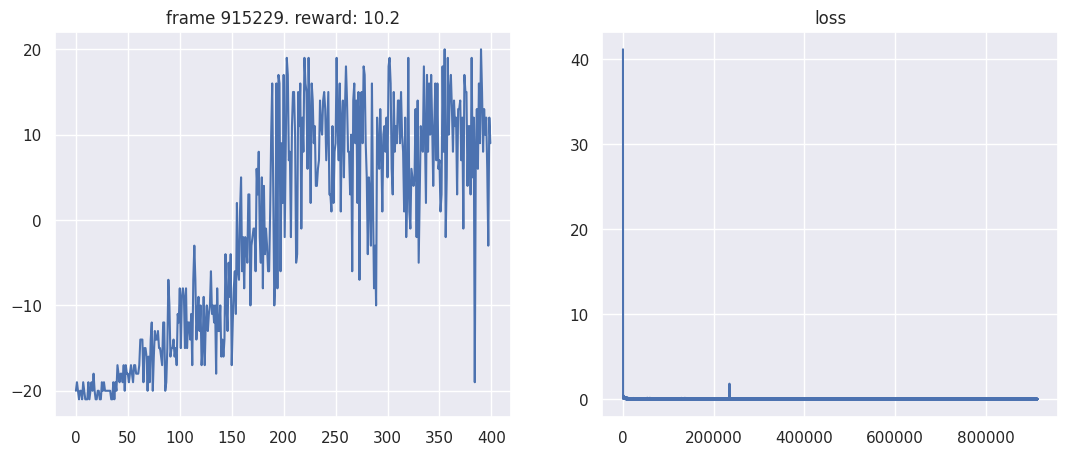

In [18]:
plot(timesteps, returns, losses)

### Prepare trained model for submission

Export to onnx, test final performance, etc.

**TODO**: Export your model. It should be enough to insert the correct path to your checkpoint.

In [22]:
# load model from checkpoint
checkpoint_path = save_path #'/content/gdrive/MyDrive/colab-drive/model-2022_03_28-10_01_18.p' # TODO insert your path here
dqn, _, _ = load_checkpoint(checkpoint_path, device=device) 

Loading checkpoint gdrive/MyDrive/Deep_Reinforcement_Learning/model_as2_big_env/minigrid-model-2023_05_22-15_13_23.pt


In [23]:
state = env.reset()
state_for_onnx = state[np.newaxis, :] # set batch-size=1 - important for evaluation on challenge server
print(state_for_onnx.shape)

(1, 4, 84, 84)


In [25]:
# save model parameters for submitting solution using the following line of code
onnx_path = 'gdrive/MyDrive/Deep_Reinforcement_Learning/model_as2_big_env/submission.onnx' #f "/content/gdrive/MyDrive/colab-drive/submission.onnx"
torch.onnx.export(dqn, # model
                  torch.tensor(state_for_onnx, dtype=torch.float), # example model input
                  onnx_path, # file path
                  export_params=True, # save trained parameters
                  opset_version=10,
                  do_constant_folding=True)
                  # input_names=['input'],
                  # output_names=['output'],
                  # dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                  #               'output' : {0 : 'batch_size'}}) 

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



<ipython-input-9-b57b2382879a>:28: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = torch.tensor(x, dtype=torch.float).to(device=device)
<ipython-input-9-b57b2382879a>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float).to(device=device)


In [26]:
# Check your model using onnx
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

In [27]:
from onnx2pytorch import ConvertModel
dqn = ConvertModel(onnx.load(onnx_path))
dqn = dqn.to(device)
dqn.eval()

/usr/local/lib/python3.10/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


ConvertModel(
  (Cast_/Cast_output_0): Cast(dtype=torch.float32)
  (Cast_/Cast_1_output_0): Cast(dtype=torch.float32)
  (Conv_/features/features.0/Conv_output_0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (Relu_/features/features.1/Relu_output_0): ReLU(inplace=True)
  (Conv_/features/features.2/Conv_output_0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (Relu_/features/features.3/Relu_output_0): ReLU(inplace=True)
  (Constant_/Constant_output_0): Constant(constant=tensor([ 1, -1], device='cuda:0'))
  (Reshape_/Reshape_output_0): Reshape(shape=None)
  (Gemm_/fc/fc.0/Gemm_output_0): Linear(in_features=2592, out_features=256, bias=True)
  (Relu_/fc/fc.1/Relu_output_0): ReLU(inplace=True)
  (Gemm_23): Linear(in_features=256, out_features=6, bias=True)
)

In [28]:
# test on the env using onnx model
return_ = []
for i in range(5):
  state = env.reset()
  ret = 0
  done = False
  while not done:
    state_tensor = torch.tensor(state, dtype=torch.float, device=device)
    state_tensor = state_tensor.unsqueeze(dim=0)
    q_actions = dqn(state_tensor).detach().cpu().numpy()
    action = np.argmax(q_actions)
    state, r, done, _ = env.step(action)
    ret += r
  print(ret)
  return_.append(ret)

print("Average Return:", np.mean(return_))

19.0
20.0
19.0
20.0
20.0
Average Return: 19.6


### Record video of your Agent

In [30]:
import glob
import glob
import io
import base64
from gym.wrappers import Monitor
# start virtual display
# from pyvirtualdisplay import Display
# pydisplay = Display(visible=0, size=(640, 480))
# pydisplay.start()
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env_video(env):
    env = Monitor(env, './video', force=True)
    return env

In [31]:
video_env = wrap_env_video(env)
state = video_env.reset()
ret = 0
done = False
while not done:
  state_tensor = torch.tensor(state, dtype=torch.float, device=device)
  state_tensor = state_tensor.unsqueeze(dim=0)
  q_actions = dqn(state_tensor).detach().cpu().numpy()
  action = np.argmax(q_actions)
  state, r, done, _ = video_env.step(action)
  ret += r
video_env.close()
print(f"Episode Return: {ret}")
show_video() # if not shown properly, just download the video in the "video" folder

Episode Return: 19.0
Could not find video
